# Rule-Based Model

In [ ]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/KPMG 캡스톤/사무총조사/BaseTable4_중복제거_수행주체추가.csv')

<ipython-input-3-93b913c832f7>:1: DtypeWarning: Columns (5,6,19,20,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/KPMG 캡스톤/사무총조사/BaseTable4_중복제거_수행주체추가.csv')


In [ ]:
with open("/content/drive/MyDrive/KPMG 캡스톤/사무총조사/수행주체/subject_list.pkl","rb") as f:
    subject_list = pickle.load(f)

# BaseTable4_중복제거2.csv 만들기

In [ ]:
index1 = df[(df['법령명'] == '석탄산업법 시행령') & (df['조번호'] == '42_2') & (df['항번호'] == 5)].index
index2 = df[(df['법령명'] == '석탄산업법 시행령') & (df['조번호'] == '42_2') & (df['항번호'] == 6)].index

df = df.drop(index1, axis = 0)
df = df.drop(index2, axis = 0)

# BaseTable4_중복제거2.csv로 rule_based 적용

In [ ]:
def rule_based(df):
  df['rule_based'] = 1

  # 조문이 결측치인 행
  df.loc[df['조문'].isnull(), 'rule_based'] = 0

  # '^제.*\)$' 표현 0으로
  df.loc[(df['조문'].notnull()) & (df['조문'].str.match(r'^제.*\)$')), 'rule_based'] = 0
  df.loc[(df['조문'].notnull()) & (df['조문'].str.match(r'제\d+조$')), 'rule_based'] = 0

  # '^제(\d+)(장|절)' 표현 0으로
  df.loc[(df['조문'].notnull()) & (df['조문'].str.match(r'^제(\d+)(장|절|편)')), 'rule_based'] = 0

  # 조문제목 == '목적'|'정의' 0으로
  df.loc[((df['조문제목'].notnull()) & ((df['조문제목'] == '목적') | (df['조문제목'] == '정의'))), 'rule_based'] = 0

  # 삭제된 조문 0으로
  df.loc[((df['조문'].str.contains("삭제 <"))|(df['조문'].str.contains("삭제<"))), 'rule_based'] = 0

  # 조문이 '목적', '명칭'뿐인 것
  df.loc[(df['조문'].notnull()) & ((df['조문'].str.match(r"\d+\. 목적")) | (df['조문'] == '목적')), 'rule_based'] = 0
  df.loc[(df['조문'].notnull()) & ((df['조문'].str.match(r"\d+\. .*명칭")) | (df['조문'] == '명칭')), 'rule_based'] = 0

  # 조문에서 사무판단 무조건 0인 표현들
  df.loc[(df['조문'].notnull()) & (df['조문'].str.match(r'.*있는 경우$')), 'rule_based'] = 0
  df.loc[(df['조문'].notnull()) & (df['조문'].str.match(r'.*없게 된 경우$')), 'rule_based'] = 0
  df.loc[(df['조문'].notnull()) & (df['조문'].str.match(r'\d+\. .*거짓이나 그 밖의 부정한 방법으로 지정을 받은 경우')), 'rule_based'] = 0
  df.loc[(df['조문'].notnull()) & (df['조문'].str.match(r'.*의사를 밝히는 경우')), 'rule_based'] = 0
  df.loc[(df['조문'].notnull()) & (df['조문'].str.match(r'\d+\. .*인정되는 경우')), 'rule_based'] = 0
  df.loc[(df['조문'].notnull()) & (df['조문'].str.match(r'.*친족이었던 경우')), 'rule_based'] = 0
  df.loc[(df['조문'].notnull()) & (df['조문'].str.match(r'.*대리인이었던 경우')), 'rule_based'] = 0
  df.loc[(df['조문'].notnull()) & (df['조문'].str.match(r'\d+\..*인증을 받은 경우')), 'rule_based'] = 0

  df.loc[(df['조문'].notnull()) & (df['조문'].str.match(r'.*후견인$')), 'rule_based'] = 0
  df.loc[(df['조문'].notnull()) & (df['조문'].str.match(r'\d+\. .*소재지')), 'rule_based'] = 0
  df.loc[(df['조문'].notnull()) & (df['조문'].str.match(r'\d+\. .*정관')), 'rule_based'] = 0
  df.loc[(df['조문'].notnull()) & (df['조문'].str.match(r'\d+\. .*계획서')), 'rule_based'] = 0
  df.loc[(df['조문'].notnull()) & (df['조문'].str.match(r'\d+\. .*서류')), 'rule_based'] = 0
  df.loc[(df['조문'].notnull()) & (df['조문'].str.match(r'\d+\. .*상호$')), 'rule_based'] = 0
  df.loc[(df['조문'].notnull()) & (df['조문'].str.match(r'\d+\. .*증명서')), 'rule_based'] = 0
  df.loc[(df['조문'].notnull()) & (df['조문'].str.match(r'\d+\. .*경매')), 'rule_based'] = 0

  df.loc[(df['조문'].notnull()) & (df['조문'].str.match(r'\d+\. .*공고의 방법')), 'rule_based'] = 0
  df.loc[(df['조문'].notnull()) & (df['조문'].str.match(r'\d+\. .*대통령령으로 정하는 사항')), 'rule_based'] = 0
  df.loc[(df['조문'].notnull()) & (df['조문'].str.match(r'\d+\. .*되지 아니한 자')), 'rule_based'] = 0
  df.loc[(df['조문'].notnull()) & (df['조문'].str.match(r'\d+\. .*그 밖에 필요한 사항')), 'rule_based'] = 0
  df.loc[(df['조문'].notnull()) & (df['조문'].str.match(r'.*협회는 법인으로 한다')), 'rule_based'] = 0

  return df

In [ ]:
tqdm.pandas()

In [ ]:
df = rule_based(df)

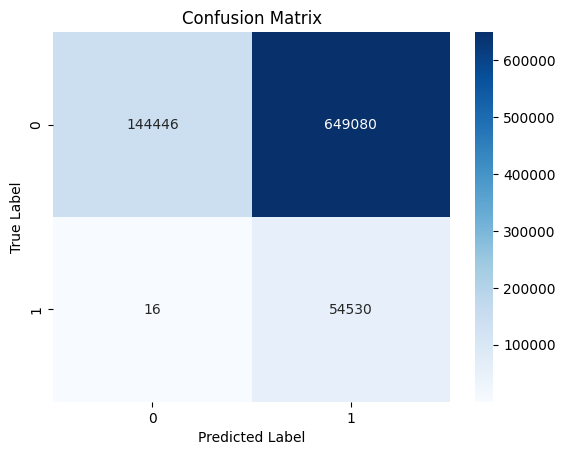

In [ ]:
conf_matrix = confusion_matrix(df['사무판단'], df['rule_based'])

# heatmap으로 confusion matrix를 시각화
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()